In [1]:
%load_ext autoreload
%autoreload 2

#Imports from this projects
import auxiliary.util as util
util.set_wd_to_package_root()
import auxiliary.config as config
import auxiliary.grid2op_util as g2o_util
from auxiliary.generate_action_space import action_identificator
import data_preprocessing_analysis.imitation_data_preprocessing as idp

#Mathematics
import math
import numpy as np
from scipy.stats import entropy
from scipy.spatial import distance
from sklearn.metrics import confusion_matrix

#Collections
import collections
from collections import Counter

#File manipulation
import os
import json
from pathlib import Path

import pandas as pd #Data manipulation & analsysis
import grid2op #Grid simulation
import matplotlib.pyplot as plt #Plotting
import ipdb #Debugger
import re #Regular expressions
import functools #Higher-order functions
from tqdm import tqdm #Progress bar

In [2]:
config = config.get_config()

In [3]:
util.set_wd_to_package_root()
import auxiliary.config as config
config = config.get_config()
import grid2op
env = grid2op.make('rte_case14_realistic')

tutor_data_path = config['paths']['tutor_imitation']
ts_in_day = config['rte_case14_realistic']['ts_in_day']

line_disabled_to_consider = [-1,0,1,2,3,4,5,6,10,12,13,15,16,19]
line_group1 = [-1,0,1,2,3,4,5,6,12]
line_group2 = [13,15,16,19]

In [4]:
idp.get_filepaths(tutor_data_path)

[PosixPath('data/tutor_generated_data/records_chronics_lout:-1_dnthreshold:0.97/records_chronic:28_dayscomp:28.npy'),
 PosixPath('data/tutor_generated_data/records_chronics_lout:-1_dnthreshold:0.97/records_chronic:609_dayscomp:28.npy'),
 PosixPath('data/tutor_generated_data/records_chronics_lout:-1_dnthreshold:0.97/records_chronic:183_dayscomp:28.npy'),
 PosixPath('data/tutor_generated_data/records_chronics_lout:-1_dnthreshold:0.97/records_chronic:52_dayscomp:28.npy'),
 PosixPath('data/tutor_generated_data/records_chronics_lout:-1_dnthreshold:0.97/records_chronic:309_dayscomp:28.npy'),
 PosixPath('data/tutor_generated_data/records_chronics_lout:-1_dnthreshold:0.97/records_chronic:598_dayscomp:28.npy'),
 PosixPath('data/tutor_generated_data/records_chronics_lout:-1_dnthreshold:0.97/records_chronic:250_dayscomp:28.npy'),
 PosixPath('data/tutor_generated_data/records_chronics_lout:-1_dnthreshold:0.97/records_chronic:827_dayscomp:28.npy'),
 PosixPath('data/tutor_generated_data/records_chro

In [5]:
# Initialize counters
action_counter = Counter()
sequence_counter = Counter()
sequence_length_counter = Counter()

#Define action identifier that links action indexes to actions
action_ider = action_identificator(env)

#Loop over filepaths
for filepath in tqdm(idp.get_filepaths(tutor_data_path)):
    
    #Ignore certain outage-topologies
    line_disabled, _, _, _ = idp.extract_data_from_filepath(filepath.relative_to(tutor_data_path))
    if line_disabled not in line_disabled_to_consider:
        continue
    
    # Load a single file with raw datapoints
    raw_chronic_datapoints = np.load(filepath)
    
    # Define a sequence data object
    sequence = []
    subs_in_sequence = []
    
    # Loop over datapoints
    for action_idx, timestep in raw_chronic_datapoints[:,(0,4)]:
        
        action_idx = int(action_idx)
        timestep  = int(timestep)
        action = action_ider.get_set_topo_vect(action_idx)
        action_subid = util.argmax_f(g2o_util.tv_groupby_subst(action,
                                                               [3, 6, 4, 6, 5, 6, 3, 2, 5, 3, 3, 3, 4, 3]),
                                     sum)
        
        action_counter[action_idx] += 1
        
        reset_sequence = False
        if action_idx == -1:
            reset_sequence = True
        elif sequence:
            if (sequence[-1][1] != timestep-1 or
                g2o_util.ts_to_day(sequence[-1][1], ts_in_day) != g2o_util.ts_to_day(timestep, ts_in_day) or
                action_subid in subs_in_sequence):
                reset_sequence = True

            
        if reset_sequence and sequence:
            #Save sequence
            sequence_actions = [a for a,ts in sequence]
            sequence_counter[tuple(sequence_actions)] += 1
            sequence_length_counter[len(sequence)] += 1
            #Reset sequence
            sequence = []
            subs_in_sequence = []
            
        if action_idx != -1:
            sequence.append((action_idx, timestep))
            subs_in_sequence.append(action_subid)
            
            
            
        
#         # If, terminiation condition for a sequence: 
#         #     The action is a do-nothing action OR 
#         #     two timesteps are not consecutive OR
#         #     two timesteps are not in the same day OR
#         #     the acted-on substatation is already in the sequence
#         # then save the sequence (if it is not empty), and reset the sequence
#         if (action_idx == -1 or
#            (sequence and (sequence[-1][1] != timestep-1 or
#                           g2o_util.ts_to_day(sequence[-1][1], ts_in_day) != g2o_util.ts_to_day(timestep, ts_in_day)) or
#            action_subid in subs_already_acted_on_in_sequence)):
            
#             # Save the sequence if not empty
#             if sequence:
#                 sequence_length_counter[len(sequence)] += 1
                
            
#             if len(sequence)>-1:
#                 sequence_actions = [a for a,ts in sequence]
#                 sequence_counter[tuple(sequence_actions)] += 1
                
#             # Reset the sequence
#             if action_idx == -1:
#                 sequence = []
#                 subs_already_acted_on_in_sequence = []
#             else:
#                 sequence = [(action_idx, timestep)]
#                 subs_already_acted_on_in_sequence = [action_subid]
                
#         # If the sequence is not terminated, if the action is not do-nothing, add it to the sequence
#         elif action_idx != -1:
#             sequence.append((action_idx, timestep))
#             subs_already_acted_on_in_sequence.append(action_subid)
#         else:
#             assert False, 'Either of above conditions should be true: this statement should not be reached'

100%|██████████| 997/997 [00:02<00:00, 336.58it/s]


#### Sequence length

Text(0, 0.5, 'Frequency')

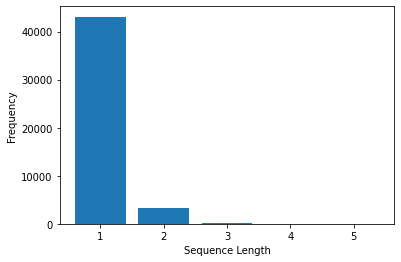

In [14]:
max_sequence_length = max(sequence_length_counter.keys())
rnge = np.arange(1,max_sequence_length+1)
plt.bar([str(i) for i in rnge], 
        [sequence_length_counter[i] for i in rnge])
#plt.title("Sequence length distribution")

plt.xlabel("Sequence Length")
plt.ylabel("Frequency")

#### Sequence frequency

Text(0, 0.5, 'Frequency')

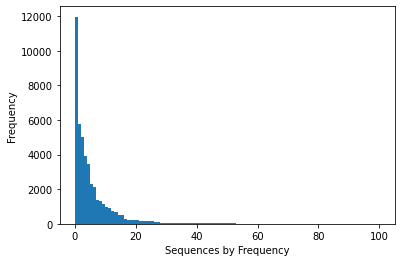

In [17]:
weight = [n for _,n in sequence_counter.most_common()][0:100]
plt.hist(range(len(weight)), weights=weight,bins=range(len(weight)+1))
#plt.title("Distribution of sequence frequency for frequencies")

plt.xlabel("Sequences by Frequency")
plt.ylabel("Frequency")

Inspecting sequence distributions for sequences larger than one

Text(0, 0.5, 'Frequency')

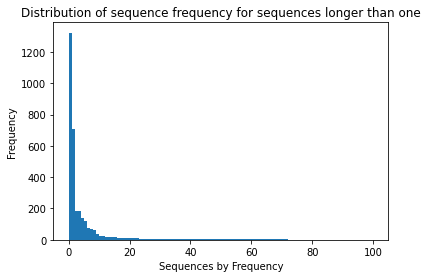

In [16]:
filtered_sequence_counter = Counter({x: count for x, count in sequence_counter.items() if len(x)>1})
weight = [n for _,n in filtered_sequence_counter.most_common()][0:100]
plt.hist(range(len(weight)), weights=weight,bins=range(len(weight)+1))
plt.title("Distribution of sequence frequency for sequences longer than one")

plt.xlabel("Sequences by Frequency")
plt.ylabel("Frequency")

#### Ignoring action ordering

Text(0.5, 1.0, 'Distribution of unordered sequence frequency')

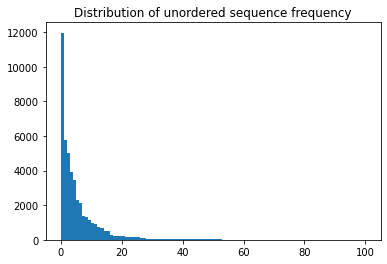

In [9]:
set_seq_counter = Counter()
for seq,n in sequence_counter.most_common():
    set_seq_counter[tuple(set(seq))] += n
weight = [n for _,n in set_seq_counter.most_common()][0:100]
plt.hist(range(len(weight)), weights=weight,bins=range(len(weight)+1))
plt.title("Distribution of unordered sequence frequency")

Text(0.5, 1.0, 'Distribution of unorderer sequence frequency for sequences longer than one')

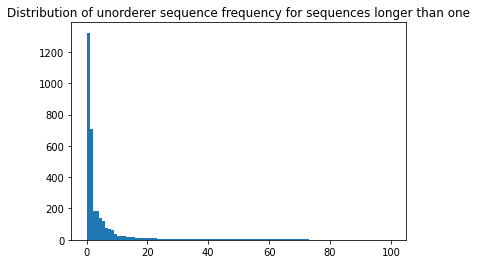

In [10]:
filtered_sequence_counter = Counter({x: count for x, count in sequence_counter.items() if len(x)>1})

set_seq_counter = Counter()
for seq,n in filtered_sequence_counter.most_common():
    set_seq_counter[tuple(set(seq))] += n
weight = [n for _,n in set_seq_counter.most_common()][0:100]
plt.hist(range(len(weight)), weights=weight,bins=range(len(weight)+1))
plt.title("Distribution of unorderer sequence frequency for sequences longer than one")

#### Frequent action analysis

In [11]:
frequent_actions = [a for a,c in action_counter.most_common() if c>1000]
frequent_actions

[96, 38, 28, 33, 31, 6, 24, 44, 61, 37, 64]

In [12]:
n_freq_action_by_sequence_length_counter = Counter()
for seq, n in sequence_counter.items():
    for act in seq:
        n_freq_action_by_sequence_length_counter[len(seq)] += n if act in frequent_actions else 0

<ipython-input-13-0fe958cd4b49>:2: RuntimeWarning: invalid value encountered in true_divide
  perc_freq_act_per_seq_len = np.array([n_freq_action_by_sequence_length_counter[i] for i in rng])/np.array([sequence_length_counter[i]*i for i in rng])


Text(0, 0.5, 'Percentage of frequent actions')

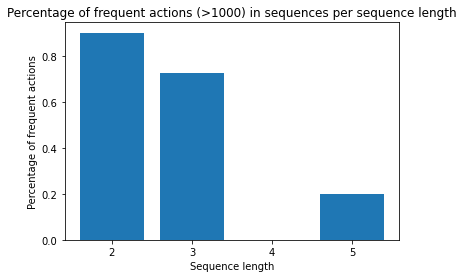

In [13]:
rng = np.arange(2,6)
perc_freq_act_per_seq_len = np.array([n_freq_action_by_sequence_length_counter[i] for i in rng])/np.array([sequence_length_counter[i]*i for i in rng])
plt.bar([str(i) for i in rng],perc_freq_act_per_seq_len)
plt.title('Percentage of frequent actions (>1000) in sequences per sequence length')
plt.xlabel('Sequence length')
plt.ylabel('Percentage of frequent actions')